<a href="https://colab.research.google.com/github/talitmr/text_analysis_word_embeddings_skip_gram/blob/main/word_embed_skip_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word Embeddings and Skip Gram 

##1. Data Preparation



In [ ]:
#libraries

import re
import spacy
import torch
import torch.nn.functional as F
import torchtext.legacy as torchtext
import random
import pandas as pd
import numpy as np
 
import time
from nltk.stem import SnowballStemmer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download("punkt")
from nltk import pos_tag_sents
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.sentiment.util import mark_negation
 
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
with open('/content/gdrive/MyDrive/cbt_test.txt', "r") as books:
    BOOKS = books.read()
books.close()


First of all, I pick the book Alice's Adventures in Wonderland by Lewis Caroll. In this section, my steps are in the below:

1) The book is in the test dataset so I only upload the test data.

2) As you know there are several books in the test file. So firstly, I  stated the places of where the books begin by searching '_BOOK_TITLE_' phrase's indexes. And then I only took Alice from the whole data.

3) After that I remove the 'CHAPTER' phrase using finditer module with splitting according to dot('.').

4) Next step is lowering all letters and removing punctuations.

5) And then I tokenize each phrase storing in a list named by alice_tok.

6) I defined a function in order to remove stopwords and also additional stop words can be removed.

7) I choose not to remove defined stopwords. However I found some words that meant anything such as 'rrb','lrb', 'rsb', 'lsb' and ' '. I removed them in the data.

8) Also, I defined stemmer and lemmatizer which can be used for preprocessing but after testing some cases I decided not to use them.

9) I looked that occurence frequency of the tokens.

10) Then, I make the dataframe which contains the token frequencies, probabilities, unique tokens and probability of keeping the word values.

11) I made subsampling. I used probability of keeping the word values smaller than 0.1 in order to lower the size of the most frequent tokens. In the subsampling, my roadmap is first storing the unique tokens indexes in a list and then randomly removing them according to possibility values.

12) After decreasing the most frequent tokens number, I applied the skip gram structure to the data using context size is 1.

13) In order to make positive labeling according to Skip-Gram I stored context word and targets in a dictionary.

14) Next step is making another dataframe full of positive labeled data. 

15) Another important part is negative sampling. I write an algorithm that makes negative sampling. Firstly, I stored the positevly labeled data in a list for each token and then I randomly choosed the pairs which they will have negative labels. For each token a new list produced which removed the positive label pairs. And then for each token random n many target was chosen randomly. n is decided by using the probability of the context token and negative sampling size which is defined by me. Negatively labeled data was also stored in the new dataframe.

16) Positively and negatively labeled dataframes were concataned.

17) Dataframe was turned into integers.

18) Final version of dataframe was downloaded as a csv file.


In [ ]:
BOOKS

In [ ]:
## In this piece of code, I found the starting number of the each book in the BOOKS file.
## and stored them into a list.

list_books_start = []
for match in re.finditer("_BOOK_TITLE_", BOOKS):
  list_books_start.append(match.span()[0])

list_books_start

[0, 593691, 744738, 1162266, 1445415]

In [ ]:
## So now I can extract the book that I chose Alice's Adventures in Wonderland by Lewis Caroll by
## searching by book's name.

for l in range(len(list_books_start)):
  if "Lewis_Carroll___Alice's_Adventures_in_Wonderland.txt.out" in BOOKS[list_books_start[l]:list_books_start[l]+100]:
    alice = BOOKS[list_books_start[l]:list_books_start[l+1]]

len_book_title = len("_BOOK_TITLE_ : Lewis_Carroll___Alice's_Adventures_in_Wonderland.txt.out ")
alice = alice[len_book_title:]
print('first 100 characters of the book :', alice[:100])
print('last 100 characters of the book :', alice[-100:])

first 100 characters of the book : CHAPTER I. Down the Rabbit-Hole Alice was beginning to get very tired of sitting by her sister on th
last 100 characters of the book :  a pleasure in all their simple joys , remembering her own child-life , and the happy summer days .



In [ ]:
## In the data there are useless words for the model like "CHAPTER", Again the same strategy, I found the word "CHAPTER"'s location and store them in a list.

list_chapters = []
for match in re.finditer("CHAPTER", alice):
  list_chapters.append(match.span()[0])
print('number of chapters in the book :',len(list_chapters))

number of chapters in the book : 12


In [ ]:
alice_cleaned = ""
for sentence in alice.split("."):
    if not (re.search("CHAPTER", sentence, flags=re.IGNORECASE)):
        alice_cleaned = alice_cleaned + sentence
 

In [ ]:
list_chapters_cleaned = []
for match in re.finditer("CHAPTER", alice_cleaned):
  list_chapters_cleaned.append(match.span()[0])

print("number of remaining 'chapters' in the book :",len(list_chapters_cleaned))

number of remaining 'chapters' in the book : 0


In [ ]:
print('first 100 characters of the book :', alice_cleaned[:100])
print('last 100 characters of the book :', alice_cleaned[-100:])

first 100 characters of the book :  Down the Rabbit-Hole Alice was beginning to get very tired of sitting by her sister on the bank , a
last 100 characters of the book : d a pleasure in all their simple joys , remembering her own child-life , and the happy summer days 



In [ ]:
## making lower whole text and removing the punctuations
def nopunc_lower(text):
  text = text.lower()
  text_nopunc = "".join([char for char in text if char not in string.punctuation])
  return text_nopunc


In [ ]:
alice_np = nopunc_lower(alice_cleaned)
alice_np

' down the rabbithole alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing to do  once or twice she had peeped into the book her sister was reading  but it had no pictures or conversations in it   and what is the use of a book   thought alice  without pictures or conversation  \nso she was considering in her own mind lrb as well as she could  for the hot day made her feel very sleepy and stupid rrb  whether the pleasure of making a daisychain would be worth the trouble of getting up and picking the daisies  when suddenly a white rabbit with pink eyes ran close by her \nthere was nothing so very remarkable in that  nor did alice think it so very much out of the way to hear the rabbit say to itself   oh dear \noh dear \ni shall be late  \nlrb when she thought it over afterwards  it occurred to her that she ought to have wondered at this  but at the time it all seemed quite natural rrb  but when the rabbit actually took a watch out of its waist

In [ ]:
alice_tok = word_tokenize(alice_np)


In [ ]:
def remove_stopwords(words, add_stop_words):

  stop_words = stopwords.words('english')
  print('default stopwords length :', len(stop_words))

  for word in add_stop_words:
    stop_words.append(word)
  
  print('stopwords length after adding additional ones:', len(stop_words))

  filtered_words = [word for word in words if word not in stop_words]

  return filtered_words


In [ ]:
additional_stopwords = ['rrb', 'lrb', 'rsb', 'lsb']
alice_nostopwords = remove_stopwords(alice_tok, additional_stopwords )

default stopwords length : 179
stopwords length after adding additional ones: 183


In [ ]:
for word in alice_tok:
  if word in additional_stopwords:
    alice_tok.remove(word)

In [ ]:
print('Length of the text after removing to CHAPTER names : ', len(alice_tok))
print('Length of the text after removing the stop words : ', len(alice_nostopwords))

Length of the text after removing to CHAPTER names :  27032
Length of the text after removing the stop words :  12333


In [ ]:
def stemmer(text):
  porter = PorterStemmer()
  return [porter.stem(word)for word in text]


In [ ]:
alice_stem = stemmer(alice_tok)
alice_stem_nostopwords = stemmer(alice_nostopwords)
print(alice_stem[:10])
print(alice_stem_nostopwords[:10])

['down', 'the', 'rabbithol', 'alic', 'wa', 'begin', 'to', 'get', 'veri', 'tire']
['rabbithol', 'alic', 'begin', 'get', 'tire', 'sit', 'sister', 'bank', 'noth', 'twice']


In [ ]:
def get_lemmatizer_pos(pos):
    pos_start = pos[0] # Takes the first letter to simplify the POS tag
    if pos_start == "J":
        return wn.ADJ
    elif pos_start == "V":
        return wn.VERB
    elif pos_start == "R":
        return wn.ADV
    else:
        return wn.NOUN

In [ ]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)   
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
lemmatizer = WordNetLemmatizer()
def lemma(text):
  sentences = sentence_tokenizer.tokenize(text)
  sentences_tokens = [tokenizer.tokenize(sentence) for sentence in sentences]
  tokens_pos = [pos_tag for pos_tags in pos_tag_sents(text) for pos_tag in pos_tags]
  lemmas = [lemmatizer.lemmatize(token[0], pos=get_lemmatizer_pos(token[1])) for token in tokens_pos]
  return lemmas


In [ ]:
alice_lemma = lemma(alice_np)

In [ ]:
sp = spacy.load('en_core_web_sm')

In [ ]:
alice_lemma = []
for word in sp(alice_np):
  alice_lemma.append(word.lemma_)
alice_lemma[:10]

[' ', 'down', 'the', 'rabbithole', 'alice', 'be', 'begin', 'to', 'get', 'very']

In [ ]:
for word in alice_lemma:
  if word == ' ':
    alice_lemma.remove(word)
print(alice_lemma[:10])

['down', 'the', 'rabbithole', 'alice', 'be', 'begin', 'to', 'get', 'very', 'tired']


In [ ]:
alice_postag = pos_tag(alice_tok)

In [ ]:
def wordListToFreqDict(word):
    wordfreq = [word.count(p) for p in word]
    return dict(list(zip(word,wordfreq)))

In [ ]:
freq = wordListToFreqDict(alice_tok)
for k in sorted(freq, key=freq.get, reverse=True)[:15]:
  print(k,freq[k])

the 1627
and 863
to 721
a 630
it 591
she 549
i 542
of 507
said 462
you 411
alice 395
was 367
in 366
that 313
as 262


In [ ]:
def get_freq(data):
  freq_dict = {}

  freq = wordListToFreqDict(data)
  data_word = []
  data_freq = []
  for k in sorted(freq, key=freq.get, reverse=True):
    freq_dict[k] = freq[k]
    data_freq.append(freq[k])
    data_word.append(k)
  
  return data_freq, data_word

data_freq, data_word = get_freq(alice_tok)

In [ ]:
def set_df(data_word, data_freq):
  data = pd.DataFrame({'word': data_word,
                       'freq': data_freq})
  data['prob'] = data['freq']/len(data_freq)
  data['pw'] = (np.sqrt(data['prob']/0.001)+1)*(0.001/data['prob'])
  
  data['prob'] 

  return data

data = set_df(data_word, data_freq)


In [ ]:
data.head()

,word,freq,prob,pw
0,the,1627,0.632828,0.041332
1,and,863,0.335667,0.057561
2,to,721,0.280436,0.063281
3,a,630,0.245041,0.067963
4,it,591,0.229872,0.070307


In [ ]:
data.tail()

,word,freq,prob,pw
2566,sorrows,1,0.000389,4.174434
2567,joys,1,0.000389,4.174434
2568,remembering,1,0.000389,4.174434
2569,childlife,1,0.000389,4.174434
2570,happy,1,0.000389,4.174434


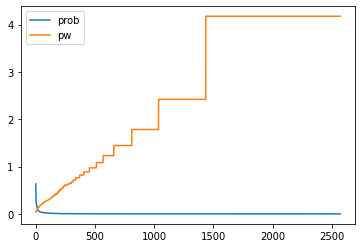

In [ ]:
data[['prob','pw']].plot()

In [ ]:
len(alice_tok)

27032

# SUBSAMPLING

In [ ]:
for row in data.itertuples():
  word_drop_index_list = []
  if data.loc[row.Index,'pw'] < 0.1:
    for i in range(len(alice_tok)):
      if alice_tok[i] == data.loc[row.Index,'word']:
        word_drop_index_list.append(i)

    n_drop = int(data.loc[row.Index, 'freq'] * (1-data.loc[row.Index, 'pw']))
    drop_list = random.sample(word_drop_index_list, n_drop)

    i = 0
    for dr in sorted(drop_list):
     alice_tok.pop(dr-i)
     i=i+1

len(alice_tok)


19265

In [ ]:
data_freq, data_word = get_freq(alice_tok)

data_cleaned = set_df(data_word, data_freq)

In [ ]:
data_cleaned.head()

,word,freq,prob,pw
0,as,262,0.101906,0.108873
1,her,247,0.096072,0.112433
2,nt,217,0.084403,0.120696
3,at,211,0.082069,0.122570
4,s,200,0.077791,0.126235


# SKIP GRAM

In [ ]:
CONTEXT_SIZE = 1  
 
data_sg = []
for i in range(CONTEXT_SIZE, len(alice_tok) - CONTEXT_SIZE):
    target = alice_tok[(i - CONTEXT_SIZE):(i)]+ alice_tok[(i+1): (i+1 + CONTEXT_SIZE)]      
    context = alice_tok[i]
    data_sg.append((context, target))
 
print(data_sg[:10])

[('rabbithole', ['down', 'beginning']), ('beginning', ['rabbithole', 'get']), ('get', ['beginning', 'very']), ('very', ['get', 'tired']), ('tired', ['very', 'sitting']), ('sitting', ['tired', 'by']), ('by', ['sitting', 'her']), ('her', ['by', 'sister']), ('sister', ['her', 'on']), ('on', ['sister', 'bank'])]


In [ ]:
positive_label_words = {}
for row in data_cleaned.itertuples():
  word_list = []
  
  for i in range(len(data_sg)):
    if data_cleaned.loc[row.Index, 'word'] == data_sg[i][0]:
      word_list.append(data_sg[i][1][0])
      word_list.append(data_sg[i][1][1])

      positive_label_words[data_cleaned.loc[row.Index, 'word']] = word_list


In [ ]:
positive_label_words['rabbithole']

['down', 'beginning', 'large', 'under', 'again', 'went', 'down', 'yet']

In [ ]:
def positive_labeling(data_sg, context_size):
  df = pd.DataFrame(columns = ['context','target','label'])
  for i in range(len(data_sg)):
    df=df.append({'context': data_sg[i][0],
                  'target': data_sg[i][1][0],
                  'label': 1 }, ignore_index=True)
    df=df.append({'context': data_sg[i][0],
                  'target': data_sg[i][1][1],
                  'label': 1 }, ignore_index=True)
    
  return df

df = positive_labeling(data_sg, 1)

In [ ]:
df.head(10)

,context,target,label
0,rabbithole,down,1
1,rabbithole,beginning,1
2,beginning,rabbithole,1
3,beginning,get,1
4,get,beginning,1
5,get,very,1
6,very,get,1
7,very,tired,1
8,tired,very,1
9,tired,sitting,1


# NEGATIVE SAMPLING

In [ ]:
def negative_sampling(data,tokenized_text, negative_sampling_size):

  df_neg = pd.DataFrame(columns = ['context','target','label'])
  for row in data.itertuples():
    random_choice_list = []
    whole_word_list = list(np.unique(tokenized_text))

    for el in whole_word_list:
      if el not in positive_label_words[data.loc[row.Index,'word']]:
        random_choice_list.append(el.item())

    for k in range(negative_sampling_size):
      df_neg = df_neg.append({'context': data.loc[row.Index,'word'],
                              'target': random.sample(random_choice_list,1)[0],
                              'label': 0 }, ignore_index=True)

  return df_neg

df_neg = negative_sampling(data_cleaned, alice_tok, 3)

In [ ]:
df_last = pd.concat([df,df_neg])
df_last.reset_index(level=0, inplace = True, drop = True)
df_last

,context,target,label
0,rabbithole,down,1
1,rabbithole,beginning,1
2,beginning,rabbithole,1
3,beginning,get,1
4,get,beginning,1
...,...,...,...
46234,childlife,dodo,0
46235,childlife,different,0
46236,happy,suppressed,0
46237,happy,pardoned,0


In [ ]:
df_last = df_last.sample(frac = 1)
df_last.reset_index(level=0, drop=True, inplace=True)

In [ ]:
numbering_dict = {}
for row in data_cleaned.itertuples():
  numbering_dict[data_cleaned.loc[row.Index,'word']] = row.Index
  

In [ ]:
df_last_num = df_last.copy()
for row in df_last.itertuples():
  df_last_num.loc[row.Index, 'context'] = numbering_dict[df_last.loc[row.Index, 'context']]
  df_last_num.loc[row.Index, 'target'] = numbering_dict[df_last.loc[row.Index, 'target']]

In [ ]:
df_last_num

,context,target,label
0,8,142,1
1,87,961,1
2,26,187,1
3,67,60,1
4,1884,570,0
...,...,...,...
46234,1405,10,1
46235,88,4,1
46236,386,50,1
46237,16,21,1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df_last_num.to_csv('df_last_num.csv', index=False)
files.download('df_last_num.csv')

df_last.to_csv('df_last.csv', index=False)
files.download('df_last.csv')

In [ ]:
train_perc = 0.6
val_test_perc = 0.2
n_train = int(train_perc*len(df_last))
n_val = int((train_perc+val_test_perc)*len(df_last))

train_text = df_last[:n_train]
val_text = df_last[n_train:n_val]
test_text = df_last[n_val:]

train_text.to_csv('train_text.csv', index=False)
files.download('train_text.csv')

val_text.to_csv('val_text.csv', index=False)
files.download('val_text.csv')

test_text.to_csv('test_text.csv', index=False)
files.download('test_text.csv')

In [ ]:
train_num = df_last_num[:n_train]
val_num = df_last_num[n_train:n_val]
test_num = df_last_num[n_val:]

train_num.to_csv('train_num.csv', index=False)
files.download('train_num.csv')

val_num.to_csv('val_num.csv', index=False)
files.download('val_num.csv')

test_num.to_csv('test_num.csv', index=False)
files.download('test_num.csv')

In [ ]:
df_last['ct'] = df_last['context'] + ' ' + df_last['target']
df_last = df_last[['ct', 'label']]

In [ ]:
from google.colab import files
train = df_last[:n_train]
val = df_last[n_train:n_val]
test = df_last[n_val:]

train.to_csv('train.csv', index=False)
files.download('train.csv')

val.to_csv('val.csv', index=False)
files.download('val.csv')

test.to_csv('test.csv', index=False)
files.download('test.csv')

##2. Preprocessing and Data Loader


In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In this part, I tried to make dataloader using the data which is made by Alice in Wonderland Books by appliying subsampling, negative sampling etc. Firstly, I want to make sure that the data form is usable in this part. So, I downloaded several versions of data. First data form consists of words' indexes which are unique values for each unique word and has a label. Second form consists first forms word i.e. original version. Third and last one consists context and target word's combinations and labels. I tried all of these datasets in the later part. In this part I use below steps:

1) First I create Field for Context and TARGET, and LabelField for LABEL.

2) And then using TabularDataset.splits I call the train, validation and test sets from the corresponding folder.

3) After that I built the vocab for CONTEXT,TARGET and LABEL using all train, validation and test datasets together.

4) Using next and iter, I made batches for train, validation and test iterations.



In [ ]:
model_data = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/df_last.csv")
model_data_num = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/df_last_num.csv")

#train_text = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/train_text.csv")
#val_text = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/val_text.csv")
#test_text = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/test_text.csv")

#train_num = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/train_num.csv")
#val_num = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/val_num.csv")
#test_num = pd.read_csv("/content/gdrive/MyDrive/IS784_Assignment2_data/test_num.csv")

In [ ]:
from torchtext.legacy import data
from torchtext.legacy import datasets

CONTEXT = data.Field(use_vocab=True)
#TARGET = data.Field(use_vocab=True)
LABEL = data.LabelField()

In [ ]:
fields = [('context', CONTEXT), ('label', LABEL)]

In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '/content/gdrive/MyDrive/IS784_Assignment2_data',
                                        train = 'train.csv',
                                        validation = 'val.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [ ]:
CONTEXT.build_vocab(train_data,valid_data,test_data)
#TARGET.build_vocab(train_data,valid_data,test_data)
LABEL.build_vocab(train_data,valid_data,test_data)

In [ ]:
print(CONTEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fe7afe56f50>>, {'<unk>': 0, '<pad>': 1, 'as': 2, 'her': 3, 'nt': 4, 'at': 5, 's': 6, 'on': 7, 'had': 8, 'with': 9, 'all': 10, 'but': 11, 'for': 12, 'they': 13, 'so': 14, 'be': 15, 'not': 16, 'very': 17, 'do': 18, 'what': 19, 'this': 20, 'little': 21, 'he': 22, 'is': 23, 'out': 24, 'one': 25, 'down': 26, 'there': 27, 'up': 28, 'if': 29, 'would': 30, 'his': 31, 'then': 32, 'about': 33, 'no': 34, 'have': 35, 'know': 36, 'them': 37, 'could': 38, 'were': 39, 'went': 40, 'like': 41, 'again': 42, 'herself': 43, 'or': 44, 'when': 45, 'did': 46, 'queen': 47, 'thought': 48, 'off': 49, 'the': 50, 'time': 51, 'how': 52, 'me': 53, 'into': 54, 'see': 55, 'm': 56, 'who': 57, 'king': 58, 'your': 59, 'well': 60, 'now': 61, 'turtle': 62, 'my': 63, 'began': 64, 'an': 65, 'its': 66, 'by': 67, 'll': 68, 'gryphon': 69, 'mock': 70, 'quite': 71, 'hatter': 72, 'are': 73, 'think': 74, 'way': 75, 'just': 76, 'here': 77, 'th

In [ ]:
train_iter,val_iter,test_iter = torchtext.data.BucketIterator.splits(
    (train_data, valid_data,test_data), batch_size=32, 
                            sort_key=lambda x: len(x.context), shuffle=True)

In [ ]:
test_iter

In [ ]:
train_batch = next(iter(train_iter))
val_batch = next(iter(val_iter))
test_batch = next(iter(test_iter))

In [ ]:
train_batch


[torchtext.legacy.data.batch.Batch of size 32]
	[.context]:[torch.LongTensor of size 2x32]
	[.label]:[torch.LongTensor of size 32]

##3. Skip-gram with Logistic Regression


In this part, firstly I write te logistic regression model. And then I defined the loss function, optimizer and other hyperparameters which are embedding dimension, hidden layer dimension, learning rate and epoch. Following that I tried to train the model but I could not make the model work without any errors. 

In [ ]:
class skipgram(nn.Module):

    def __init__(self, vocab_size, embedding_dim,hidden_dim):  
        super(skipgram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)   
        self.relu1 = nn.ReLU()        
        self.linear2 = nn.Linear(hidden_dim, vocab_size) 
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, inputs):
        embeds = mul(self.embeddings(inputs)).view(1,-1)   
        x = self.linear1(embeds)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)   
        return x
        
    def get_word_embedding(self, word):
        word = torch.tensor([CONTEXT.vocab.itos[word]])
        return self.embeddings(word).view(1,-1)

In [ ]:
EMBEDDING_DIM = 4  # For this example, Let’s choose 5 as our embedding dimension. You are welcome to try with different dimension sizes.
loss_function = nn.NLLLoss()  # The negative log likelihood loss is useful when we have N number of clases
HIDDEN_DIM = 10

model = skipgram(len(CONTEXT.vocab), EMBEDDING_DIM,HIDDEN_DIM)   #If you want to work on the GPU you can add the `.cuda()` to end. Because it is a small network, we will work on CPU.

optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

In [ ]:
losses = []   # for keeping the losses
EPOCHS = 800  # because of our small dataset we need to increase our epoch count
j =0
for epoch in range(EPOCHS):    
    total_loss = 0
    i=0 
    j +=1
    for context,  label in train_batch:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
          
        #print("Context id: ",context_idxs)
      
        # forward pass
        log_probs = model(context)

        # calculate the Loss
        loss = loss_function(log_probs, label)
        #print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()
        i += 1
        # 
        total_loss += loss.item()
    if j%50 ==0:
      print("epoch", j ,"avarage epoch loss:", total_loss/i)
    losses.append(total_loss)